### Введение.

Для планирования рекламной компании на 2017 год в интернет - магазине "Стримчик", необходимо из открытых источников проанализировать исторические данные о продажах игр (оценки пользователей и экспертов, жанры и платформы) и выявить определяющие успешность игры закономерности, что позволит сделать ставку на потенциально популярный продукт. 

Описание данных:

- `Name` — название игры;
- `Platform` — платформа;
- `Year_of_Release` — год выпуска;
- `Genre` — жанр игры;
- `NA_sales` — продажи в Северной Америке (миллионы проданных копий);
- `EU_sales` — продажи в Европе (миллионы проданных копий);
- `JP_sales` — продажи в Японии (миллионы проданных копий);
- `Other_sales` — продажи в других странах (миллионы проданных копий);
- `Critic_Score` — оценка критиков (максимум 100);
- `User_Score` — оценка пользователей (максимум 10);
- `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию;

### Шаг 1. Изучение общей информации о данных.

Импорт библиотек и данных, вывод общей информации о таблице.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as mt
from scipy import stats as st

from io import BytesIO
import requests

import warnings
warnings.filterwarnings('ignore')

spreadsheet_id = '1aNoS4zrGAmoYudmNtVuhzhhzgHi5hUg002ivQsyctZg'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)

try:
    
    games = pd.read_csv(BytesIO(r.content))
        
except:
    
    games = pd.read_csv('/datasets/games.csv')

display(games.info())
display(games.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


None

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


### Изучение общей информации о данных. Вывод.

Таблица состоит из 16715 строк и 10 столбцов. В столбцах: `Name`, `Year_of_Release`, `Genre`, `Critic_Score`, `User_Score` и `Rating` присутствуют пропуски. В столбцах `Year_of_Release` и `User_Score` не соответствует тип данных.

### Шаг 2. Подготовка данных.

Замена верхнего регистра на нижний в названиях столбцов. В таблице `games` дубликаты отсутствуют.

In [2]:
games.columns = games.columns.str.lower()
display(games.duplicated().sum())

0

Обработка столбца `name`. В столбце `name` присутствует 2 `NaN` в строках с индексами `659` и `14244`, большинство данных в других столбцах для указанных строк, так же отсутствуют. Такую пару строк удаляем.

In [3]:
display(games[games['name'].isna() == True])
games = games.dropna(subset=['name']).reset_index(drop=True)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Пропуски в столбце `year_of_release` заполняем медианой в соответствии с столбцом `platform`. Столбец `year_of_release` приводим к целочисленному типу `int64`, а не к `datetime64[ns]`, так как пришлось бы использовать дополнительно `[year_of_release].dt.year`, а тип получился бы `int`

In [4]:
# для всех уникальных значений в platform
for platform in games['platform'].unique(): 
    # рассчитываем медиану в year_of_release с учетом platform
    median = games.loc[games['platform'] == platform, 'year_of_release'].median()
    # замена NaNов в year_of_release на медиану по платформе
    games.loc[(games['year_of_release'].isna()) & (games['platform'] == platform), 'year_of_release'] = median

games['year_of_release'] = games['year_of_release'].astype('int64')

В столбце `critic_score` присутствуют пропуски (49%). Оставим.

В столбце `user_score` присутствуют пропуски, а так же аббревиатура `tbd`, которая может быть расшифрована, как: to be determined (будет определено) или to be decided (будет решено). Видимо, на момент выгрузки данных, оценка пользователей была еще не определена. Избавимся от `tbd` заменой на `NaN`, а все пропуски (55%) оставим.

In [5]:
# замена tbd в столбце user_score на NaN
games.loc[games['user_score'] == 'tbd', 'user_score'] = None
games['user_score'] = games['user_score'].astype('float64')

В столбце `rating` присутствуют пропуски, а так же рейтинг `K-A`, который впоследствии был заменен на `E`. В таких строках произведена соответствующая замена. Пропуски в столбце `rating` заполнены в соответствии с наиболее популярным рейтингом в жанре

In [6]:
# создание таблицы: жанр - популярный рейтинг
games_pop_r = games.groupby('genre')['rating'].apply(lambda x: x.mode().iloc[0]).reset_index()
# замена пропусков в rating в соответствии с жанр - популярный рейтинг
for genre in games['genre'].dropna().unique():
    games.loc[(games['rating'].isna()) & (games['genre'] == genre), 'rating'] = \
    games_pop_r.loc[games_pop_r['genre'] == genre, 'rating'].values[0]
# замена в rating K-A на E
games.loc[(games['rating'] == "K-A"), 'rating'] = "E" 

Создание столбца sum_sales_region с суммарными продажами во всех регионах

In [7]:
games['sum_sales_region'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

### Подготовка данных. Вывод:

В таблице `games` дубликаты не обнаружены. В названиях столбцов надписи заменены с верхнего регистра на нижний.

- в столбце `name` в строках с индексами `659` и `14244` присутствовало 2 `NaN`, большинство данных в других столбцах для указанных строк, отсутствовало. Строки с указанными индексами удалил;
- Пропуски в столбце `year_of_release` заполнил медианой по столбцу. Столбец `year_of_release` привел к целочисленному типу `int64`, а не к `datetime64[ns]`, так как пришлось бы использовать дополнительно `[year_of_release].dt.year`, и тип получился бы `int`;
- В столбце `critic_score` пропуски заменил медианным значением по столбцу в соотвестсвии с жанром (столбец `genre`);
- В столбце `user_score` присутствовали пропуски, а так же аббревиатура `tbd`, которая могла быть расшифрована, как: to be determined (будет определено) или to be decided (будет решено). Видимо, на момент выгрузки данных, оценка пользователей была еще не определена. Избавился от `tbd` заменой на `NaN`, и все пропуски заменил средним по столбцу `user_score` в соответствии с жанром (`genre`);
- В столбце `rating` пропуски заполнил в соответствии с наиболее популярным рейтингом в жанре, так же рейтинг `K-A` заменен на `E` (официально смена названия с 1998г);

Был создан столбец `sum_sales_region` с суммарными продажами во всех регионах.

### Шаг 3. Исследовательский анализ данных.

Вывод информации о том сколько игр выпускалось в разные годы:

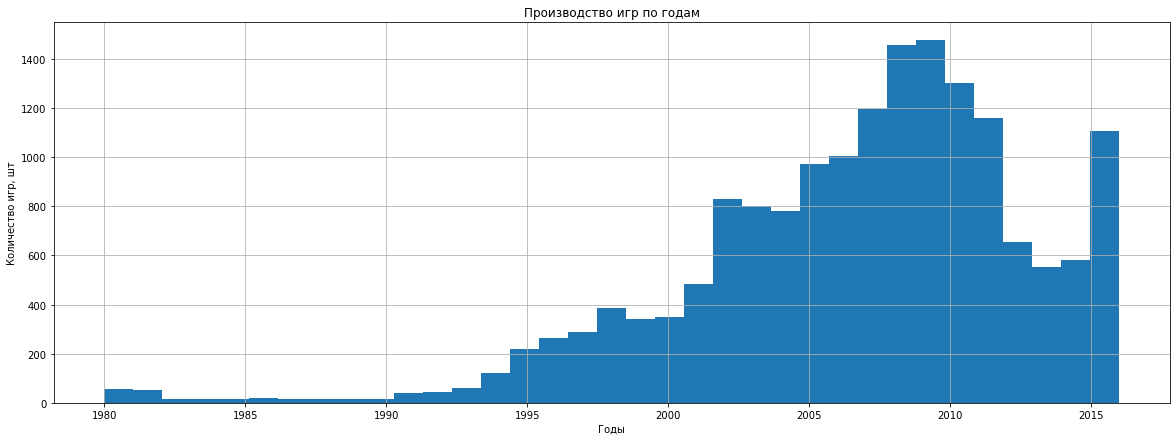

In [8]:
games['year_of_release'].hist(bins = 35, figsize = (20, 7))
plt.title('Производство игр по годам')
plt.xlabel('Годы')
plt.ylabel('Количество игр, шт')
plt.show()

Из распределения производства игр по годам видно, что в период с первой четверти 80-х до начала 90-х производство игр было не только минимальным относительно всего периода наблюдений, но и не обладало динамикой. Возможно, пероид производства игр до начала 90-х можно исключить из анализа. 

Суммарные продажи по платформам за весь наблюдаемый период:

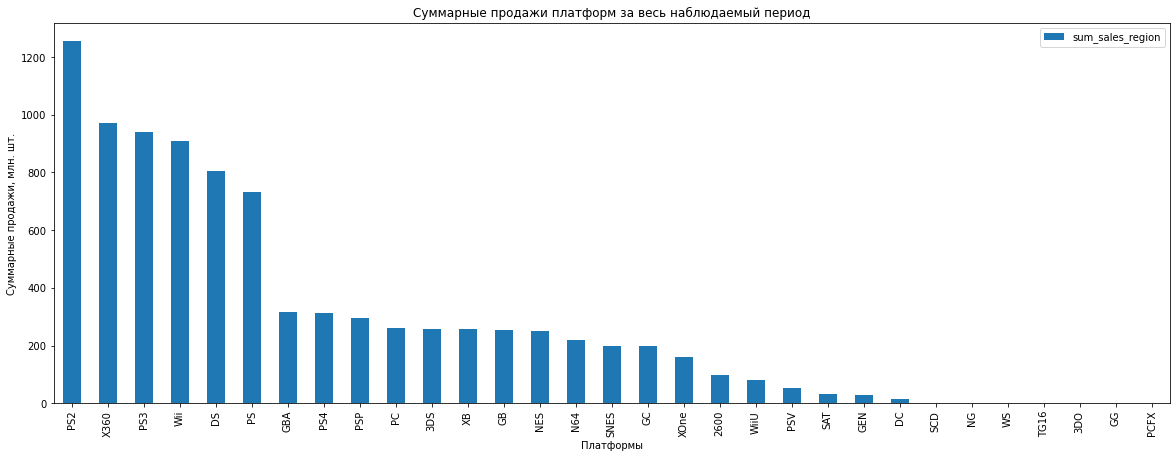

In [9]:
games.groupby('platform')['sum_sales_region'].sum().sort_values(ascending = False).reset_index().\
                                        plot.bar(x='platform', y='sum_sales_region', figsize = (20, 7))
plt.title('Суммарные продажи платформ за весь наблюдаемый период')
plt.xlabel('Платформы')
plt.ylabel('Суммарные продажи, млн. шт.')
plt.show()


Платформы с наибольшими суммарными продажами (Тор - 10):

In [10]:
top_10_platform_sales = games.groupby('platform')['sum_sales_region'].sum().sort_values(ascending = False).reset_index().head(10)
display(top_10_platform_sales)
top_10_platform_list = top_10_platform_sales['platform'].tolist()

,platform,sum_sales_region
0,PS2,1255.77
1,X360,971.42
2,PS3,939.65
3,Wii,907.51
4,DS,806.12
5,PS,730.86
6,GBA,317.85
7,PS4,314.14
8,PSP,294.05
9,PC,259.52


Top - 10 платформ с наибольшими суммарными продажами распределенных по годам.

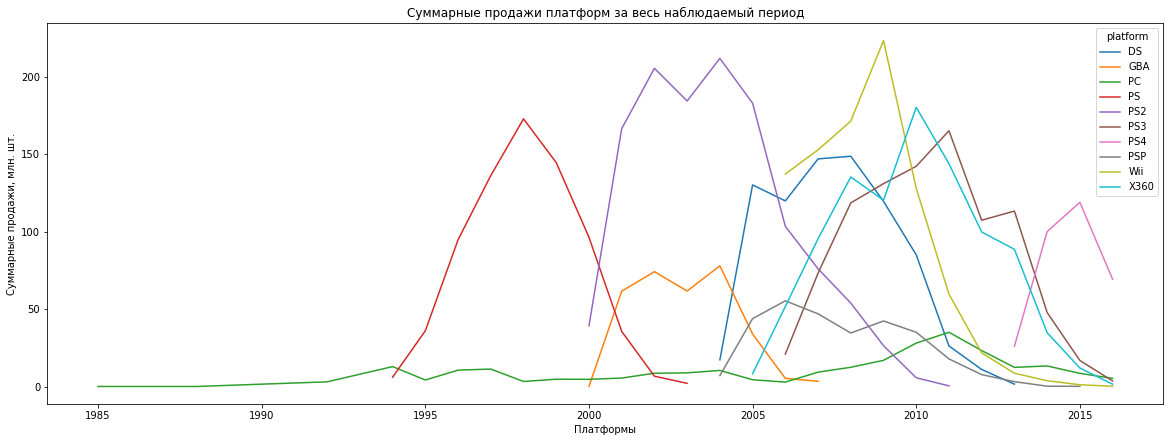

In [11]:
games.query('platform == @top_10_platform_list'). \
                                    pivot_table(index = 'year_of_release', values = 'sum_sales_region', \
                                      columns = 'platform', aggfunc = 'sum').plot(figsize = (20, 7))
plt.title('Суммарные продажи платформ за весь наблюдаемый период')
plt.xlabel('Платформы')
plt.ylabel('Суммарные продажи, млн. шт.')
plt.show()

Как видно из графика, у каждой платформы из Top - 10 за исключением платформы `PC` был свой характерный период увеличения и снижения продаж. От части, это связано с тем, что платформы появляются, а через некоторое время устаревают и сменяются новыми. Исключение составляет платформа `PC`, всплесков продаж особых нет, но продажи стабильны на всем промежутке наблюдений.

Рассчет среднего время жизни платформы из Top - 10:

In [12]:
year_live_platform = games.query('(platform == @top_10_platform_list)'). \
                                    pivot_table(index = 'year_of_release', values = 'sum_sales_region', \
                                      columns = 'platform', aggfunc = 'sum').count().reset_index()
year_live_platform.columns = ['platform', 'years']
print('Среднее время жизни платформы из Top - 10: ', year_live_platform['years'].mean(), 'лет')

Среднее время жизни платформы из Top - 10:  11.7 лет


Среднее время жизни платформы составляет 12 лет, следовательно актуальным периодом для исседования можно считать 2016г - 8 лет, то есть с 2008 по 2016 год.

Диаграмма размаха по глобальным продажам игр в разбивке по платформам за актуальный период:

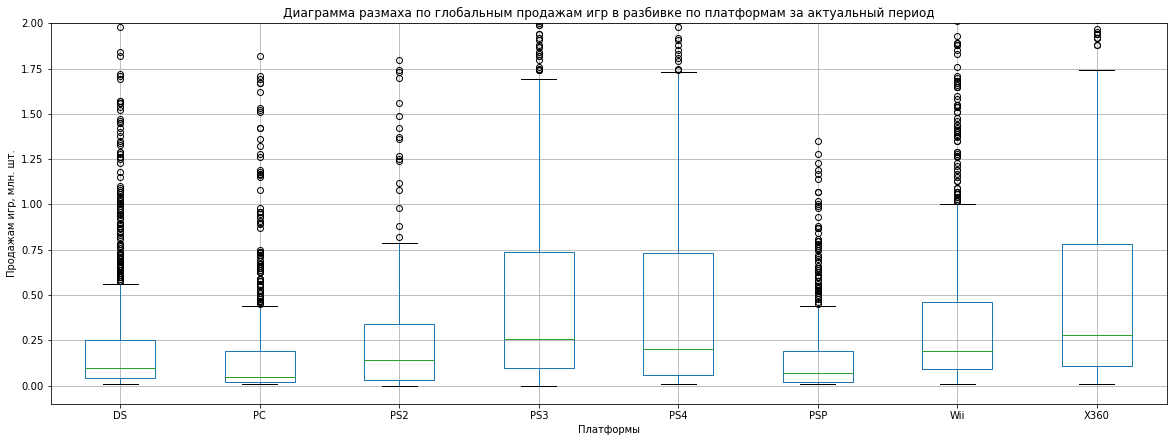

In [13]:
top_relevant_platforms_list = games.query('(platform == @top_10_platform_list) and year_of_release >= 2008'). \
                                    pivot_table(index = 'name', values = 'sum_sales_region', \
                                      columns = 'platform', aggfunc = 'sum')
top_relevant_platforms_list = top_relevant_platforms_list.transpose().reset_index()
top_relevant_platforms_list = top_relevant_platforms_list['platform'].tolist()

games.query('(platform == @top_relevant_platforms_list) and year_of_release >= 2008'). \
                                    pivot_table(index = 'name', values = 'sum_sales_region', \
                                      columns = 'platform', aggfunc = 'sum').boxplot(figsize = (20, 7))
plt.ylim(-0.1, 2)
plt.title('Диаграмма размаха по глобальным продажам игр в разбивке по платформам за актуальный период')
plt.xlabel('Платформы')
plt.ylabel('Продажам игр, млн. шт.')
plt.show()

Диаграмма размаха по средним продажам игр в разбивке по платформам за актуальный период:

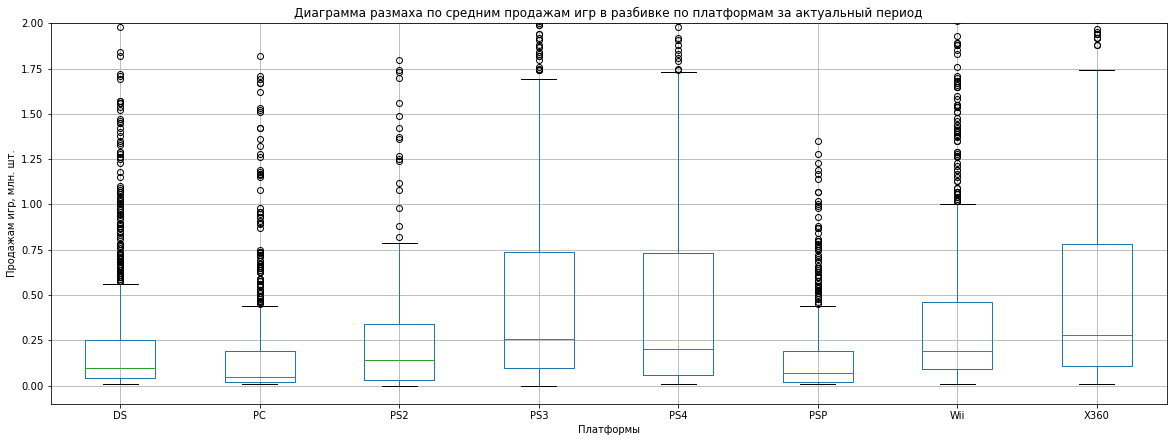

In [14]:
games.query('(platform == @top_relevant_platforms_list) and year_of_release >= 2008'). \
                                    pivot_table(index = 'name', values = 'sum_sales_region', \
                                      columns = 'platform', aggfunc = 'mean').boxplot(figsize = (20, 7))
plt.ylim(-0.1, 2)
plt.title('Диаграмма размаха по средним продажам игр в разбивке по платформам за актуальный период')
plt.xlabel('Платформы')
plt.ylabel('Продажам игр, млн. шт.')
plt.show()

В соответствии с графиками, разница в продажах игр в зависимовти от платформы присутствует. Разница между глобальными с средними продажами игр в зависимости от платформы отсутствует.

Диаграмма рассеяния и корреляция между оценкой критиков и суммарными продажами игр за актуальный период для Top - 10 платформ

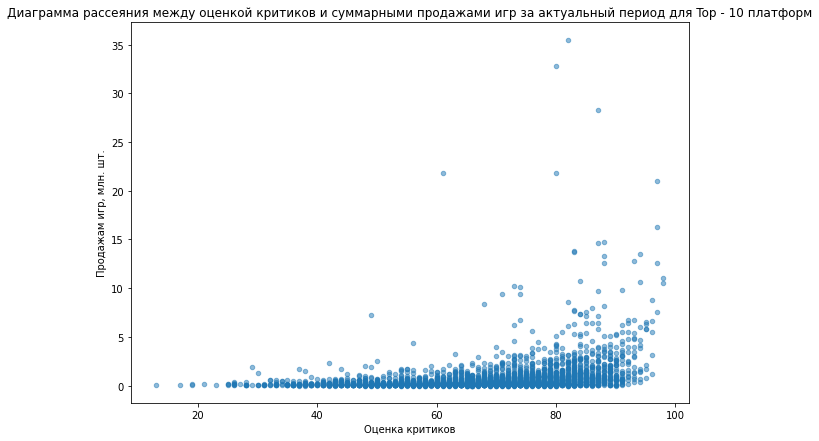

Коэффициент корреляции: 0.29359756292894185


In [15]:
top_relevant_2008_2016 = games.query('(platform == @top_relevant_platforms_list) and (year_of_release >= 2008)')
games.query('(platform == @top_relevant_platforms_list) and year_of_release >= 2008').\
                    plot(x = 'critic_score', y = 'sum_sales_region', kind = 'scatter', alpha = 0.5, figsize = (10, 7))
plt.title('Диаграмма рассеяния между оценкой критиков и суммарными продажами игр за актуальный период для Top - 10 платформ')
plt.xlabel('Оценка критиков')
plt.ylabel('Продажам игр, млн. шт.')
plt.show()
print('Коэффициент корреляции: {}'.format(top_relevant_2008_2016['critic_score'].\
                                          corr(top_relevant_2008_2016['sum_sales_region'])))

Слабая корреляция, завмсимости между оценкой критиков и суммарными продажами игр нет.

Диаграмма рассеяния и корреляция между оценкой пользователей и суммарными продажами игр за актуальный период для Top - 10 платформ

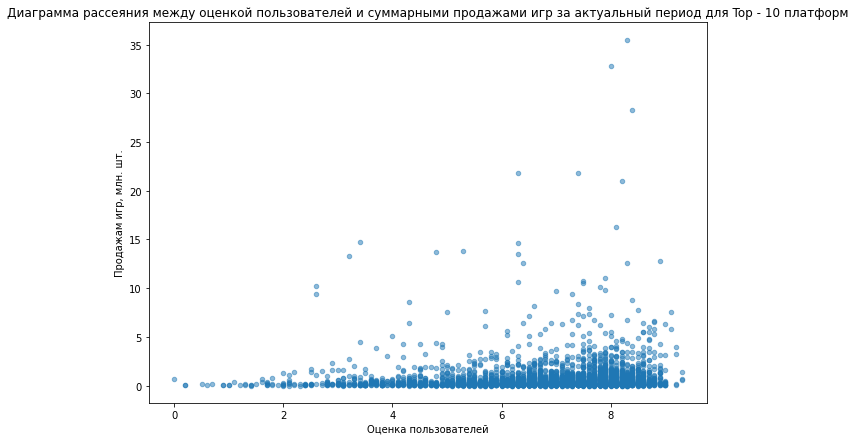

Коэффициент корреляции: 0.08379470658249491


In [16]:
games.query('(platform == @top_relevant_platforms_list) and year_of_release >= 2008').\
                    plot(x = 'user_score', y = 'sum_sales_region', kind = 'scatter', alpha = 0.5, figsize = (10, 7))
plt.title('Диаграмма рассеяния между оценкой пользователей и суммарными продажами игр за актуальный период для Top - 10 платформ')
plt.xlabel('Оценка пользователей')
plt.ylabel('Продажам игр, млн. шт.')
plt.show()
print('Коэффициент корреляции: {}'.format(top_relevant_2008_2016['user_score'].corr(top_relevant_2008_2016['sum_sales_region'])))

Очень слабая корреляция, завмсимости между оценкой пользователей и суммарными продажами игр нет.

 Влияние на продажи оценок критиков и пользователей за актуальный период по платформам.

In [17]:
for platform in top_relevant_platforms_list:
    x = games.query('(platform == @platform) and (year_of_release >= 2008)')
    print('Платформа', platform)
    print('Коэффициент корреляции (оценка критиков): {:.02}'.format(x['critic_score'].corr(x['sum_sales_region'])))
    print('Коэффициент корреляции (оценка пользователей): {:.02}'.format(x['user_score'].corr(x['sum_sales_region'])))
    print()

Платформа DS
Коэффициент корреляции (оценка критиков): 0.31
Коэффициент корреляции (оценка пользователей): 0.2

Платформа PC
Коэффициент корреляции (оценка критиков): 0.3
Коэффициент корреляции (оценка пользователей): -0.022

Платформа PS2
Коэффициент корреляции (оценка критиков): 0.34
Коэффициент корреляции (оценка пользователей): 0.12

Платформа PS3
Коэффициент корреляции (оценка критиков): 0.43
Коэффициент корреляции (оценка пользователей): 0.11

Платформа PS4
Коэффициент корреляции (оценка критиков): 0.41
Коэффициент корреляции (оценка пользователей): -0.032

Платформа PSP
Коэффициент корреляции (оценка критиков): 0.33
Коэффициент корреляции (оценка пользователей): 0.21

Платформа Wii
Коэффициент корреляции (оценка критиков): 0.23
Коэффициент корреляции (оценка пользователей): 0.13

Платформа X360
Коэффициент корреляции (оценка критиков): 0.39
Коэффициент корреляции (оценка пользователей): 0.1



Значимые коэффициенты корреляции начинаются примерно с 0.6, но, как видно из результата, ни оценки критиков, ни оценки пользователей на продажи игр не влияют.

Распределение прибыльности по жанрам за актуальные период:

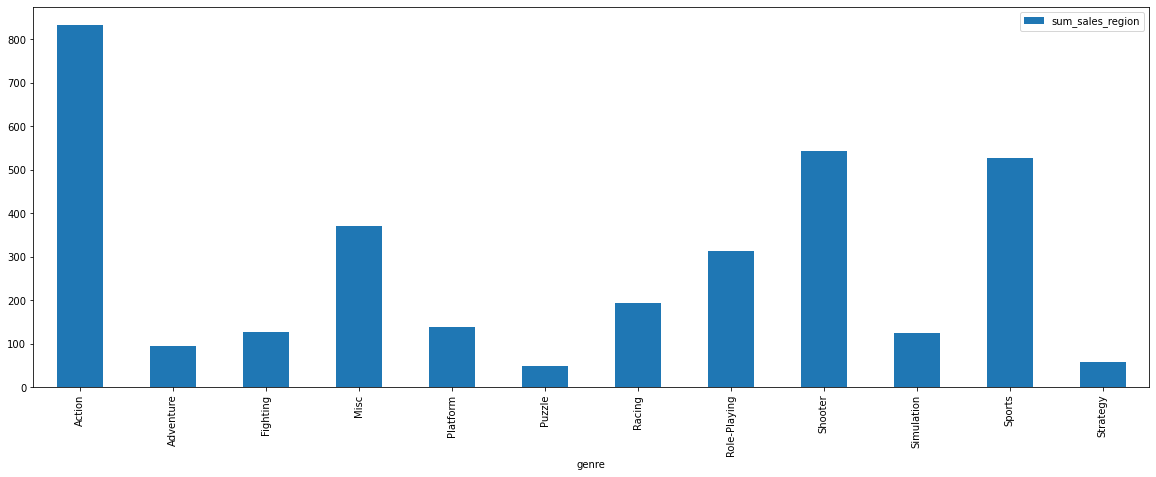

In [18]:
games.query('(platform == @top_relevant_platforms_list) and (year_of_release >= 2008)').\
                pivot_table(index = 'genre', values = 'sum_sales_region', aggfunc = 'sum').\
                plot(kind = 'bar', figsize = (20, 7))

В соответствии с графиком, можно сделать вывод, что больше всего продается игр таких жанров как: `Action`, `Shooter` и `Sports`, а меньше всего продается игр жанров: `Adventure`, `Strategy` и `Puzzle`

Распределение средней и медианной прибыльности по жанрам за актуальные период:

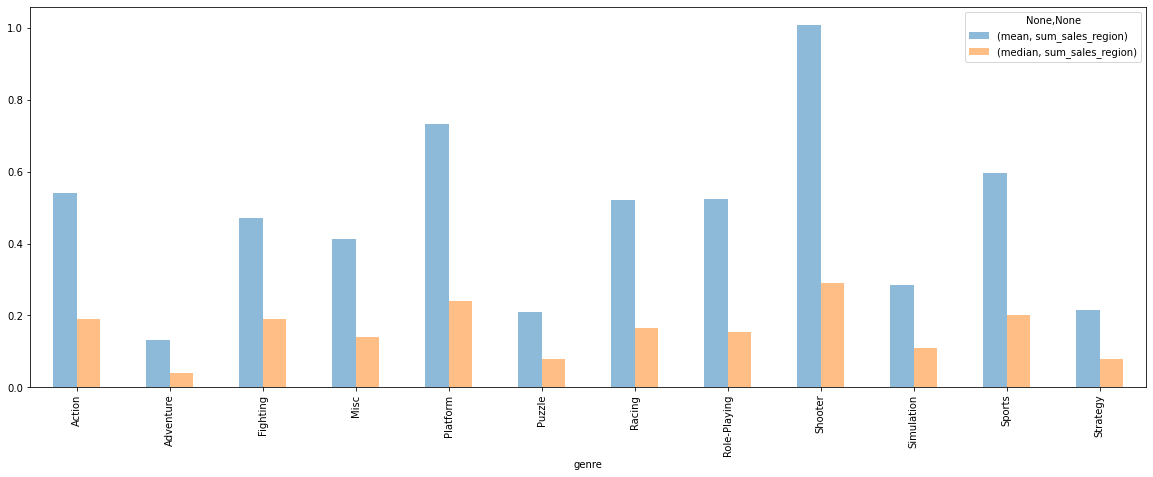

In [19]:
games.query('(platform == @top_relevant_platforms_list) and (year_of_release >= 2008)').\
                pivot_table(index = 'genre', values = 'sum_sales_region', aggfunc = ['mean', 'median']).\
                plot(kind = 'bar', figsize = (20, 7), alpha = 0.5)

В соответсивии с графиком можно сделать вывод, что игры жанров `Shooter`, `Platform`, `Sports` и `Action` являются наиболее прибыльными, в то время как игры жанров `Simulation`, `Strategy`, `Puzzle` и `Adventure` - наименее.

В целом, вывод таков: наиболее прибыльными игровыми жанрами являются Shooter и Action, так как игры этих жанров не только больше всего суммарно продаются, но и обладают высокой прибыльностью для разработчиков.

### Исследовательский анализ данных. Вывод.

- Из распределения производства игр по годам видно, что в период с первой четверти 80-х до начала 90-х производство игр было не только минимальным относительно всего периода наблюдений, но и не обладало динамикой. Возможно, пероид производства игр до начала 90-х можно исключить из анализа. 
- Самыми продаваемыми платформами (Top - 10) за весь наблюдаемый период являются (в порядке убывания, c суммарным количеством продаж, млн. шт.): `PS2 - 1255.77`, `X360 - 971.42`, `PS3 - 939.65`, `Wii - 907.51`, `DS - 806.12`, `PS - 730.86`, `GBA - 317.85`, `PS4 - 314.14`, `PSP - 294.05`, `PC - 259.52`. 
- Как видно из графика "Top - 10 платформ с наибольшими суммарными продажами распределенных по годам", у каждой платформы из Top - 10 за исключением платформы `PC` был свой характерный период увеличения и снижения продаж. От части, это связано с тем, что платформы появляются, а через некоторое время устаревают и сменяются новыми. Исключение составляет платформа `PC`, всплесков продаж особых нет, но продажи стабильны на всем промежутке наблюдений. 
- Из рассчета среднего времени жизни платформы делаем вывод, что среднее время жизни платформы из Top - 10 составляет примерно 12 лет. Следовательно, актуальным периодом для исседования можно считать 2016г - 8 лет, то есть с 2008 по 2016 год. 
- Из  диаграмм размаха по глобальным и средним продажам игр в разбивке по платформам за актуальный период делаем вывод, что разница в продажах игр в зависимовти от платформы присутствует, разница между глобальными с средними продажами игр в зависимости от платформы отсутствует. 
- Коэффицент корреляции между оценкой критиков (оценкой пользователей) и суммарными продажами игр за актуальный период для Top- 10 составляет: 0.26 и 0.0032 соответственно. Слабая корреляция, завмсимости между оценкой критиков или оценкой пользователей и суммарными продажами игр нет. 
- Из распределения прибыльности по жанрам за актуальные период, делаем вывод, что больше всего продается игр таких жанров как: `Action`, `Shooter` и `Sports`, а меньше всего продается игр жанров: `Adventure`, `Strategy` и `Puzzle`. Из распределения средней и медианной прибыльности по жанрам за актуальные период, делаем вывод, что игры жанров `Shooter`, `Platform`, `Sports` и `Action` являются наиболее прибыльными, в то время как игры жанров `Simulation`, `Strategy`, `Puzzle` и `Adventure` - наименее.

### Шаг 4. Портрет пользователя каждого региона.

Портрет пользователя каждого региона:

Самые популярные платформы (топ-5) и различия в долях продаж для региона `NA` за актуальный период:

In [20]:
top_5_platform_na_sales = games.query('year_of_release >= 2008').\
                                    groupby('platform')['na_sales'].sum().sort_values(ascending = False).reset_index().head(5)
top_5_platform_na_sales['na_share'] = top_5_platform_na_sales['na_sales'] / top_5_platform_na_sales['na_sales'].sum()
display(top_5_platform_na_sales)

,platform,na_sales,na_share
0,X360,497.42,0.331090
1,PS3,352.49,0.234623
2,Wii,342.90,0.228239
3,DS,200.82,0.133669
4,PS4,108.74,0.072379


Самые популярные платформы (топ-5) и различия в долях продаж для региона `EU` за актуальный период:

In [21]:
top_5_platform_eu_sales = games.query('year_of_release >= 2008').\
                                    groupby('platform')['eu_sales'].sum().sort_values(ascending = False).reset_index().head(5)
top_5_platform_eu_sales['eu_share'] = top_5_platform_eu_sales['eu_sales'] / top_5_platform_eu_sales['eu_sales'].sum()
display(top_5_platform_eu_sales)

,platform,eu_sales,eu_share
0,PS3,296.81,0.314387
1,X360,237.32,0.251374
2,Wii,174.63,0.184972
3,PS4,141.09,0.149445
4,PC,94.24,0.099821


Самые популярные платформы (топ-5) и различия в долях продаж для региона `JP` за актуальный период:

In [22]:
top_5_platform_jp_sales = games.query('year_of_release >= 2008').\
                                    groupby('platform')['jp_sales'].sum().sort_values(ascending = False).reset_index().head(5)
top_5_platform_jp_sales['eu_share'] = top_5_platform_jp_sales['jp_sales'] / top_5_platform_jp_sales['jp_sales'].sum()
display(top_5_platform_jp_sales)

,platform,jp_sales,eu_share
0,3DS,100.67,0.278363
1,DS,76.67,0.212001
2,PS3,74.89,0.207079
3,PSP,61.36,0.169667
4,Wii,48.06,0.132891


Самые прибыльные жанры в регионах `NA`, `EU`, `JP` за актуальный период:

In [23]:
genre_na = games.query('year_of_release >= 2008').groupby('genre')['na_sales'].sum().sort_values(ascending = False).head(5)
genre_na = genre_na.reset_index()

genre_eu = games.query('year_of_release >= 2008').groupby('genre')['eu_sales'].sum().sort_values(ascending = False).head(5)
genre_eu = genre_eu.reset_index()

genre_jp = games.query('year_of_release >= 2008').groupby('genre')['jp_sales'].sum().sort_values(ascending = False).head(5)
genre_jp = genre_jp.reset_index()

genre_regions = pd.DataFrame()
genre_regions = pd.merge(genre_na, genre_eu, left_index=True, right_index=True)
genre_regions = genre_regions.merge(genre_jp, left_index=True, right_index=True)
genre_regions = genre_regions.drop(columns = ['na_sales', 'eu_sales', 'jp_sales'])
genre_regions.columns = ['na_sales', 'eu_sales', 'jp_sales']

genre_regions

,na_sales,eu_sales,jp_sales
0,Action,Action,Role-Playing
1,Shooter,Shooter,Action
2,Sports,Sports,Misc
3,Misc,Misc,Sports
4,Role-Playing,Role-Playing,Adventure


Как видно из таблицы, в регионах `NA` и `EU`, рейтинг самых прибыльных игровых жанров совпадает, в то время как в регионе `JP`, на первом месте жанр `Role-Playing`.

### Портрет пользователя каждого региона. Вывод.

- Самые популярные платформы (топ-5) для региона `NA` за актуальный период: `X360`, `PS3`, `Wii`, `DS`, `PS4`;
- Самые популярные платформы (топ-5) для региона `EU` за актуальный период: `PS3`, `X360`, `Wii`, `PS4`, `PC`;
- Самые популярные платформы (топ-5) для региона `JP` за актуальный период: `3DS`, `DS`, `PS3`, `PSP`, `Wii`;
- Самые прибыльные жанры в регионах `NA` и `EU` совпадаю, а регионе `JP` самым прибыльным оказался жанр: `Role-Playing`.

### Шаг 5. Проверка гипотез.

Гипотеза 1.

- Формулировка нулевой гипотезы: средние пользовательские рейтинги платформы `Xbox One` равны средним пользовательским рейтингам платформы `PC`. 
- Формулировка альтернативной гипотезы: средние пользовательские рейтинги платформы `Xbox One` не равны средним пользовательским рейтингам платформы `PC`. 

In [26]:
games_test = games.dropna()

xbox_one_user_score = games_test.query('(platform == "XOne") and (year_of_release >= 2008)')
pc_user_score = games_test.query('(platform == "PC") and (year_of_release >= 2008)')

alpha = 0.01 
results = st.ttest_ind(xbox_one_user_score['user_score'], pc_user_score['user_score'], equal_var = False)

print('p-значение:', results.pvalue) 
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
        
#display(xbox_one_user_score['user_score'].mean())
#display(pc_user_score['user_score'].mean())

p-значение: 0.17077832794973108
Не получилось отвергнуть нулевую гипотезу


6.538181818181819

6.709533468559842

Гипотеза 2.

- Формулировка нулевой гипотезы: средние пользовательские рейтинги игр жанра `Action` не равны средним пользовательским рейтингам игр жанра `Sports`.
- Формулировка альтернативной гипотезы: средние пользовательские рейтинги игр жанра `Action` равны средним пользовательским рейтингам игр жанра `Sports`.

In [25]:
genre_action = games_test.query('(genre == "Action") and (year_of_release >= 2008)')
genre_sports = games_test.query('(genre == "Sports") and (year_of_release >= 2008)')

alpha = 0.01 
# опциональный аргумент equal_var с значением False, так как нет основания полагать, 
# что выборки взяты из схожих по параметрам совокупностей
results = st.ttest_ind(genre_action['user_score'], genre_sports['user_score'], equal_var = False)

print('p-значение:', results.pvalue) 
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")    
    
#display(genre_action['user_score'].mean())
#display(genre_sports['user_score'].mean())

p-значение: 4.81943045156249e-09
Отвергаем нулевую гипотезу


### Проверка гипотез. Вывод.

В сответствии с результатом проверки гипотез, можно сделать вывод, что:

- средние пользовательские рейтинги платформы `Xbox One` равны средним пользовательским рейтингам платформы `PC`.
- средние пользовательские рейтинги игр жанра `Action` равны средним пользовательским рейтингам игр жанра `Sports`.

### Шаг 6. Общий вывод:

Для планирования рекламной компании на 2017 год в интернет - магазине "Стримчик", были проанализированны исторические данные о продажах игр и выявленны определяющие успешность игры закономерности.

Исследовательский анализ данных показал что:

- в период с первой четверти 80-х до начала 90-х производство игр было не только минимальным относительно всего периода наблюдений, но и не обладало динамикой; 
- самыми продаваемыми платформами (Top - 10) за весь наблюдаемый период являются (в порядке убывания, c суммарным количеством продаж, млн. шт.): `PS2 - 1255.77`, `X360 - 971.42`, `PS3 - 939.65`, `Wii - 907.51`, `DS - 806.12`, `PS - 730.86`, `GBA - 317.85`, `PS4 - 314.14`, `PSP - 294.05`, `PC - 259.52`; 
- у каждой платформы из Top - 10 за исключением платформы `PC` был свой характерный период увеличения и снижения продаж. От части, это связано с тем, что платформы появляются, а через некоторое время устаревают и сменяются новыми. Исключение составляет платформа `PC`, всплесков продаж особых нет, но продажи стабильны на всем промежутке наблюдений; 
- среднее время жизни платформы из Top - 10 составляет примерно 12 лет. Следовательно, актуальным периодом для исседования можно считать 2016г - 8 лет, то есть с 2008 по 2016 год; 
- разница в продажах игр в зависимовти от платформы присутствует, разница между глобальными с средними продажами игр в зависимости от платформы отсутствует; 
- завмсимости между оценкой критиков или оценкой пользователей и суммарными продажами игр нет. 
- больше всего продается игр таких жанров как: `Action`, `Shooter` и `Sports`, а меньше всего продается игр жанров: `Adventure`, `Strategy` и `Puzzle`. 
- игры жанров `Shooter`, `Platform`, `Sports` и `Action` являются наиболее прибыльными, в то время как игры жанров `Simulation`, `Strategy`, `Puzzle` и `Adventure` - наименее. 

Портрет пользователя каждого региона выглядит следующим образом:

- Самые популярные платформы (топ-5) для региона `NA` за актуальный период: `X360`, `PS3`, `Wii`, `DS`, `PS4`;
- Самые популярные платформы (топ-5) для региона `EU` за актуальный период: `PS3`, `X360`, `Wii`, `PS4`, `PC`;
- Самые популярные платформы (топ-5) для региона `JP` за актуальный период: `3DS`, `DS`, `PS3`, `PSP`, `Wii`;
- Самые прибыльные жанры в регионах `NA` и `EU` совпадаю, а регионе `JP` самым прибыльным оказался жанр: `Role-Playing`.

В результате проверки гипотез, можно сделать вывод, что:

- средние пользовательские рейтинги платформы `Xbox One` равны средним пользовательским рейтингам платформы `PC`.
- средние пользовательские рейтинги игр жанра `Action` равны средним пользовательским рейтингам игр жанра `Sports`.

В целом, наиболее прибыльными игровыми жанрами являются `Shooter` и `Action`, так как игры этих жанров не только больше всего суммарно продаются, но и обладают высокой прибыльностью для разработчиков.